# Two Stage Sequential Classifier

## Required Imports

In [603]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, ConfusionMatrixDisplay, precision_score, recall_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import label_binarize
from sklearn.utils import resample
from sklearn.utils.multiclass import unique_labels

## User Defined Functions

In [604]:
def create_confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize=None, display_labels=None, include_values=True, xticks_rotation='horizontal', values_format=None, cmap='viridis', ax=None, colorbar=True):
    
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    
    if display_labels is None:
        if labels is None:
            display_labels = unique_labels(y_true, y_pred)
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=display_labels)
    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format)

In [605]:
def specificity_score(y_true, y_pred):
    TN = 0
    FP = 0
    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y_true[i] == 0:
            TN += 1
        if y_pred[i] == 1 and y_true[i] == 0:
            FP += 1
    
    return TN / (TN + FP)

In [606]:
def positive_pv_score(y_true, y_pred):
    TP = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 1:
            TP += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1

    return TP/(TP+FP)

In [607]:
def negative_pv_score(y_true, y_pred):
    TN = 0
    FN = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            FN += 1
    
    return TN/(TN+FN) 

In [608]:
def create_ci(bootstrapped_scores, name):
    for i in range(3):
        sorted_scores = np.array(bootstrapped_scores)[:, i]
        sorted_scores.sort()
    
        confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
        confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
        print("95% Confidence interval for the {} score for class {}: [{:0.4f} - {:0.4}]".format(name, i,
        confidence_lower, confidence_upper))

In [609]:

def my_classification_report(y_test_np, y_pred):
    import torch
    y_test = torch.from_numpy(y_test_np)
    y_pred = torch.from_numpy(y_pred)
    from torchmetrics import F1Score, Accuracy, Precision, Recall
    for name, metric_cls in [
        ('Precision', Precision),
        ('Recall', Recall),
        ('F1', F1Score),
    ]:
        print(name)
        metric = metric_cls(task='multiclass', num_classes=3, average='none')(y_pred, y_test)
        for i, group in enumerate(['G34', 'SHH', 'WNT']):
            print(group, metric[i].item())
        print(f"Macro Avg: {metric.mean().item()}")
    
    print('multiclass acc:', (y_test == y_pred).sum() / len(y_test))

In [610]:
def print_metrics(y_test, y_pred):
    def print_metric(metric_name, metric):
        for i, cls_name in enumerate(['G34', 'WS']):
            print(f"{metric_name} {cls_name} {metric(y_test, y_pred, pos_label=i)}")
        print(f"{metric_name} macro {metric(y_test, y_pred, average='macro')}")
    print_metric('Precision', precision_score)
    print_metric('Recall', recall_score)
    print_metric('F1', f1_score)
    print("Acc Score: " + str.format('{0:.4f}', (accuracy_score(y_test, y_pred))))

In [611]:
def plot_roc_curve(model_name):
    sns.set()
    plt.figure(figsize=(7, 7))

    ns_preds = [0 for _ in range(len(y_test))]

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_preds)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=model_name)
    plt.xlabel('1 - Specificity (False Positive Rate)',fontsize=16)
    plt.ylabel('Sensitivity (True Positive Rate)',fontsize=16)

    plt.legend(loc='lower right')
    plt.title(f'{model_name}: ROC Curve for Test Set', fontsize=20, fontweight="semibold")
    short_auc = round(auc,4)
    plt.text(.93,.1, "AUC: " + str(short_auc), 
        horizontalalignment="center", verticalalignment="center",
        fontsize=14, fontweight="semibold")
    
    plt.show()

In [612]:
def create_intermed_confusion_matrix(model_name, model, X, y, normalize=None):
    matrix = ConfusionMatrixDisplay.from_estimator(model, X, y,
                               cmap=plt.cm.Blues,
                                  normalize=normalize)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show(matrix)
    plt.show()

In [613]:
def grid_search(model, params, X_train, y_train):
    grid = GridSearchCV(estimator=model,
                       param_grid=params,
                       scoring='accuracy',
                       cv=5,
                       n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_params_

## Data Loading

In [614]:
# load data
df = pd.read_csv("features.csv")
sex_binarized = df['sex'].map(lambda sex: {'F': 0, 'M': 1}.get(sex, -1)).to_numpy()
df['sex'] = sex_binarized
df['age'] = df['age'].map(lambda x: 0 if pd.isna(x) else x)
df.head()

,case,molecular,split,sex,age,t1_diagnostics_Versions_PyRadiomics,t1_diagnostics_Versions_Numpy,t1_diagnostics_Versions_SimpleITK,t1_diagnostics_Versions_PyWavelet,t1_diagnostics_Versions_Python,...,t2_wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,t2_wavelet-LLL_glszm_SizeZoneNonUniformity,t2_wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,t2_wavelet-LLL_glszm_SmallAreaEmphasis,t2_wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,t2_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_ZoneEntropy,t2_wavelet-LLL_glszm_ZonePercentage,t2_wavelet-LLL_glszm_ZoneVariance
0,212716,shh,1,0,35.0,v3.0.1,1.24.3,2.2.1,1.4.1,3.10.10,...,0.026191,0.000914,2512.151097,0.393754,0.651604,1918.935163,0.000685,8.103643,0.364780,73.645028
1,220204,group4,2,1,22.0,v3.0.1,1.24.3,2.2.1,1.4.1,3.10.10,...,0.045723,0.002111,2670.044883,0.435783,0.686319,1419.813827,0.001417,7.934767,0.433004,18.896570
2,234406,group4,4,1,26.0,v3.0.1,1.24.3,2.2.1,1.4.1,3.10.10,...,0.015780,0.001037,2894.365780,0.396815,0.654527,1759.160320,0.000632,8.058357,0.405493,17.069254
3,243030,shh,3,1,34.0,v3.0.1,1.24.3,2.2.1,1.4.1,3.10.10,...,1.771472,0.000828,3931.643936,0.403784,0.660745,2215.427751,0.000581,8.079126,0.175195,8279.544143
4,248063,shh,0,1,37.0,v3.0.1,1.24.3,2.2.1,1.4.1,3.10.10,...,0.617026,0.001642,1492.182540,0.370085,0.631286,848.080953,0.001149,7.561874,0.257143,613.609678


In [615]:
# obtain list of features selected from LASSO
reduced_features_list = ['sex', 'age', 't1_log-sigma-1-mm-3D_glszm_SmallAreaLowGrayLevelEmphasis', 't1_log-sigma-3-mm-3D_firstorder_Median', 't1_log-sigma-3-mm-3D_glcm_ClusterProminence', 't1_log-sigma-3-mm-3D_glrlm_LowGrayLevelRunEmphasis', 't1_log-sigma-5-mm-3D_glszm_GrayLevelVariance', 't1_original_glszm_LargeAreaHighGrayLevelEmphasis', 't1_original_glszm_LargeAreaLowGrayLevelEmphasis', 't1_original_shape_Flatness', 't1_wavelet-HHL_firstorder_Skewness', 't1_wavelet-HLL_firstorder_Mean', 't1_wavelet-HLL_glcm_Correlation', 't1_wavelet-LHL_glcm_Correlation', 't1_wavelet-LLH_glszm_LargeAreaLowGrayLevelEmphasis', 't1_wavelet-LLL_firstorder_Skewness', 't1_wavelet-LLL_glszm_ZoneVariance', 't2_log-sigma-1-mm-3D_firstorder_Mean', 't2_log-sigma-1-mm-3D_firstorder_Median', 't2_log-sigma-1-mm-3D_glcm_Correlation', 't2_log-sigma-5-mm-3D_firstorder_Kurtosis', 't2_log-sigma-5-mm-3D_glrlm_RunLengthNonUniformity', 't2_log-sigma-5-mm-3D_glszm_SmallAreaEmphasis', 't2_original_glszm_GrayLevelNonUniformity', 't2_wavelet-HHH_glrlm_RunPercentage', 't2_wavelet-HHH_glszm_LargeAreaEmphasis', 't2_wavelet-HHH_glszm_SmallAreaLowGrayLevelEmphasis', 't2_wavelet-HHL_glcm_ClusterProminence', 't2_wavelet-HHL_glrlm_LongRunHighGrayLevelEmphasis', 't2_wavelet-HHL_glszm_LargeAreaHighGrayLevelEmphasis', 't2_wavelet-HLH_glszm_SizeZoneNonUniformityNormalized', 't2_wavelet-HLL_firstorder_Mean', 't2_wavelet-LHH_firstorder_Mean', 't2_wavelet-LHH_glszm_GrayLevelNonUniformityNormalized', 't2_wavelet-LHL_glcm_Idn', 't2_wavelet-LLL_firstorder_Energy', 't2_wavelet-LLL_glcm_JointAverage', 't1_log-sigma-3-mm-3D_glrlm_ShortRunLowGrayLevelEmphasis', 't1_wavelet-HHH_firstorder_Skewness', 't1_wavelet-HHH_glszm_LargeAreaHighGrayLevelEmphasis', 't1_wavelet-HHL_glcm_ClusterProminence', 't1_wavelet-LHH_firstorder_Median', 't2_log-sigma-5-mm-3D_glcm_Imc2', 't2_original_glcm_Idmn', 't2_wavelet-LLL_firstorder_Median', 't2_wavelet-HHH_firstorder_Skewness', 't2_original_firstorder_Kurtosis', 't2_wavelet-LLL_firstorder_TotalEnergy']

## NN1: group3+4 vs rest (First Sequential)

### Data Preprocessing

In [616]:
first_features = df[reduced_features_list]

In [617]:
# Binarizing target
first_target = df["molecular"]

# Marking 0 as group3+4 and 1 as wnt
first_target = first_target.map(dict(group3=0, group4=0, shh=1, wnt=1))
print(first_target.value_counts())

molecular
0    155
1    107
Name: count, dtype: int64


In [618]:
# Train/test split
train_idx = df['split'] != 'test'
test_idx = ~train_idx
# X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(first_features, first_target, test_size = 0.25, random_state = 42)
X_train_1 = first_features[train_idx]
y_train_1 = first_target[train_idx]
X_test_1 = first_features[test_idx]
y_test_1 = first_target[test_idx]
print("TRAIN")
print(y_train_1.value_counts())

print("TEST")
print(y_test_1.value_counts())

TRAIN
molecular
0    123
1     79
Name: count, dtype: int64
TEST
molecular
0    32
1    28
Name: count, dtype: int64


In [619]:
# #NIR
# NIR_G34 = 42/66
# NIR_SHH = 14/66
# NIR_WNT = 10/66
#
# print('%.4f' % NIR_G34)
# print('%.4f' % NIR_SHH)
# print('%.4f' % NIR_WNT)

#### Resampling to Correct for Imbalance

In [620]:
first_X = pd.concat([X_train_1, y_train_1], axis = 1)
first_X_0 = first_X[first_X['molecular'] == 0]
first_X_1 = first_X[first_X['molecular'] == 1]

In [621]:
assert len(first_X_0) >= len(first_X_1)
upsampled_1 = resample(first_X_1, replace = True, n_samples = len(first_X_0), random_state = 42)
upsampled = pd.concat([upsampled_1, first_X_0])
upsampled = upsampled.sample(frac = 1, random_state = 42)

In [622]:
X_train_1 = upsampled.iloc[:, :-1]
y_train_1 = upsampled.iloc[:, -1]
print(y_train_1.value_counts())

molecular
1    123
0    123
Name: count, dtype: int64


#### Standardizing Features

In [623]:
first_names = X_train_1.columns
first_scaler = preprocessing.StandardScaler()

In [624]:
X_train_1 = first_scaler.fit_transform(X_train_1)
X_train_1 = pd.DataFrame(X_train_1, columns = first_names)

In [625]:
X_test_1 = first_scaler.transform(X_test_1)
X_test_1 = pd.DataFrame(X_test_1, columns = first_names)

#### Grid Search for Hyperparameters

In [626]:
nn_model_1_model = MLPClassifier(max_iter = 2000, random_state = 42)
nn_grid_params_1 = {'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50), (100, 50, 100)],
              'learning_rate': ['constant', 'invscaling', 'adaptive']
}

nn_params_1 = grid_search(nn_model_1_model, nn_grid_params_1, X_train_1, y_train_1)
print(nn_params_1)

{'hidden_layer_sizes': (100, 50, 100), 'learning_rate': 'constant'}


#### Model Performance

In [627]:
nn_seq_1_model = MLPClassifier(nn_params_1['hidden_layer_sizes'], max_iter=2000, random_state=42, learning_rate=nn_params_1['learning_rate'])
nn_seq_1_model.fit(X_train_1, y_train_1)
y_pred_1 = nn_seq_1_model.predict(X_test_1)
print(X_test_1.shape)
print(y_pred_1)
print(y_test_1.to_numpy())

(60, 48)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0]
[1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1
 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1]


In [660]:
from sklearn.metrics import roc_auc_score
print_metrics(y_test_1, y_pred_1)
probs = nn_seq_1_model.predict_proba(X_test_1)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_1, probs)
auc = roc_auc_score(y_test_1, probs)
print("AUC: " + str.format('{0:.4f}',auc))

Precision G34 0.5660377358490566
Precision WS 0.7142857142857143
Precision macro 0.6401617250673854
Recall G34 0.9375
Recall WS 0.17857142857142858
Recall macro 0.5580357142857143
F1 G34 0.7058823529411765
F1 WS 0.2857142857142857
F1 macro 0.4957983193277311
Acc Score: 0.5833
AUC: 0.6763


# NN2: SHH vs WNT (Second Sequential) [decomposed from rest1]

### Data Preprocessing

In [629]:
# obtain list of features selected from LASSO
second_reduced_features_list = ['t1_log-sigma-3-mm-3D_glszm_GrayLevelNonUniformityNormalized', 't1_wavelet-LHL_glcm_Correlation', 't1_wavelet-LHL_glcm_Idn', 't2_wavelet-HHL_firstorder_InterquartileRange', 't2_wavelet-LLL_firstorder_Kurtosis', 't2_log-sigma-1-mm-3D_glszm_HighGrayLevelZoneEmphasis', 'age']
print(len(second_reduced_features_list))

7


In [630]:
# second_features = df.drop(['molecular','molec_id', 'dx_date','alive','os','pfs','seg_id'], axis = 1)
# second_features = second_features[second_reduced_features_list]
second_df = df[df['molecular'].isin(['wnt', 'shh'])]
second_features = second_df[second_reduced_features_list]

In [631]:
# Binarizing target
second_target = second_df["molecular"]

# Marking 0 as shh and 1 as wnt
second_target = second_target.map({
    'shh': 0,
    'wnt': 1,
})
print(second_target.value_counts())

molecular
0    82
1    25
Name: count, dtype: int64


In [632]:
# second_target = second_target.reset_index(drop = True)
# second_features = second_features.reset_index(drop = True)

In [633]:
# Train/test split
X_train_2 = second_features[train_idx]
X_test_2 = second_features[test_idx]
y_train_2 = second_target[train_idx]
y_test_2 = second_target[test_idx]
# X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(second_features, second_target,
#                                                     test_size = 0.25, random_state = 42)
print("TRAIN")
print(y_train_2.value_counts())

print("TEST")
print(y_test_2.value_counts())

TRAIN
molecular
0    64
1    15
Name: count, dtype: int64
TEST
molecular
0    18
1    10
Name: count, dtype: int64


/tmp/ipykernel_2166935/2412312205.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_2 = second_features[train_idx]
/tmp/ipykernel_2166935/2412312205.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test_2 = second_features[test_idx]


#### Resampling to Correct for Imbalance 

In [634]:
second_X = pd.concat([X_train_2, y_train_2], axis = 1)
second_X_0 = second_X[second_X['molecular'] == 0]
second_X_1 = second_X[second_X['molecular'] == 1]

In [635]:
assert len(second_X_0) >= len(second_X_1)
second_upsampled_1 = resample(second_X_1, replace = True, n_samples = len(second_X_0), random_state = 42)
second_upsampled = pd.concat([second_upsampled_1, second_X_0])
second_upsampled = second_upsampled.sample(frac = 1, random_state = 42)

In [636]:
X_train_2 = second_upsampled.iloc[:, :-1]
y_train_2 = second_upsampled.iloc[:, -1]
print(y_train_2.value_counts())

molecular
1    64
0    64
Name: count, dtype: int64


#### Standardizing Features

In [637]:
second_names = X_train_2.columns
second_scaler = preprocessing.StandardScaler()

In [638]:
X_train_2 = second_scaler.fit_transform(X_train_2)
X_train_2 = pd.DataFrame(X_train_2, columns = second_names)

In [639]:
X_test_2 = second_scaler.transform(X_test_2)
X_test_2 = pd.DataFrame(X_test_2, columns = second_names)

### Modeling

#### Model Performance

In [640]:
nn_model_2_model = MLPClassifier(max_iter=2000, random_state=42)
nn_grid_params_2 = {'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50), (100, 50, 100)],
              'learning_rate': ['constant', 'invscaling', 'adaptive']
}

nn_params_2 = grid_search(nn_model_2_model, nn_grid_params_2, X_train_2, y_train_2)
print(nn_params_2)

{'hidden_layer_sizes': (100, 100, 50), 'learning_rate': 'constant'}


In [641]:
nn_seq_2_model = MLPClassifier(nn_params_2['hidden_layer_sizes'], max_iter=2000, random_state=42, learning_rate=nn_params_2['learning_rate'])
nn_seq_2_model.fit(X_train_2, y_train_2)
y_pred_2 = nn_seq_2_model.predict(X_test_2)

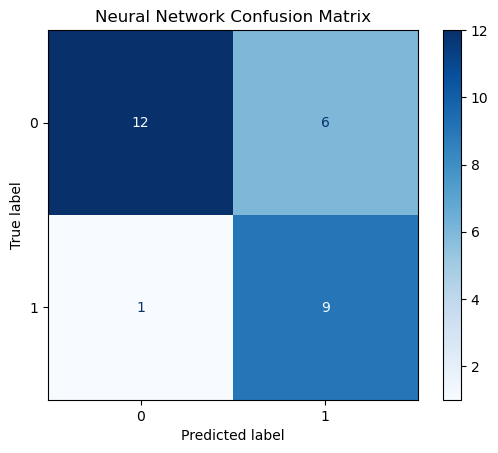

In [642]:
create_intermed_confusion_matrix('Neural Network', nn_seq_2_model, X_test_2, y_test_2)

## Testing

In [643]:
# Test features
# test_features = df.drop(['molecular','molec_id', 'dx_date','alive','os','pfs','seg_id'], axis = 1)
test_features = df.copy()
test_target = df['molecular']
# test_target = test_target.map(dict(group3 = 0, shh = 1, wnt = 2))
test_target = test_target.map({
    'group3': 0,
    'group4': 0,
    'shh': 1,
    'wnt': 2,
})

In [644]:
# Train/test split
# X_train, X_test, y_train, y_test = train_test_split(test_features, test_target,
#                                                     test_size = 0.25, random_state = 42)
X_train = test_features[train_idx]
X_test = test_features[test_idx]
y_train = test_target[train_idx]
y_test = test_target[test_idx]
print("TRAIN")
print(y_train.value_counts())

print("TEST")
print(y_test.value_counts())

TRAIN
molecular
0    123
1     64
2     15
Name: count, dtype: int64
TEST
molecular
0    32
1    18
2    10
Name: count, dtype: int64


In [645]:
# Data Preparation
# X_test = X_test.reset_index(drop = True)
# y_test = y_test.reset_index(drop = True)
# sex_binarized = X_test['sex'].map(dict(M = 1, F = 0)).to_numpy()
# X_test['sex'] = sex_binarized
X_test_reduced = X_test[reduced_features_list]

### Standardization for NN1

In [646]:
names = X_test_reduced.columns
X_test_for_first = first_scaler.transform(X_test_reduced)
X_test_for_first = pd.DataFrame(X_test_for_first, columns = names)

### Modeling

In [647]:
y_preds_after_first = nn_seq_1_model.predict(X_test_for_first)
print(y_preds_after_first)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0]


In [648]:
#keeps all that are group3+4, indifferent to shh/wnt label
group3_indices = np.where(y_preds_after_first == 0)
other_indices = np.where(y_preds_after_first != 0)

group3_preds = y_preds_after_first[group3_indices]
y_test_for_group3 = np.array(y_test)[group3_indices]

X_test_after_first_model = X_test.iloc[other_indices].reset_index(drop = True)
y_test_after_first_model = y_test.iloc[other_indices].reset_index(drop = True)

X_test_after_first_model = X_test_after_first_model[second_reduced_features_list]

### Standardization for NN2

In [649]:
X_test_after_first_model = second_scaler.transform(X_test_after_first_model)

In [650]:
#relabel original test-dictionary
#allows us to dro group3 from 2nd stage
#allows accuracy_score of binary outputs: shh now 0, wnt now 1
y_test_after_first_model = np.array(y_test_after_first_model)
y_test_after_first_model[y_test_after_first_model == 0] = -1
y_test_after_first_model[y_test_after_first_model == 1] = 0
y_test_after_first_model[y_test_after_first_model == 2] = 1

In [651]:
y_preds_after_second = nn_seq_2_model.predict(X_test_after_first_model)
print(y_preds_after_second)
print(accuracy_score(y_test_after_first_model, y_preds_after_second))

[0 1 1 0 0 1 1]
0.5714285714285714


/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


### Post-processing

In [652]:
#relabel prediction outputs to match 3-way; wnt to 2, shh to 1
#group3 is 0 already from "group3_preds" and "y_test_for_group3" derived from "group3_indices"
y_preds_after_second[y_preds_after_second == 1] = 2
y_preds_after_second[y_preds_after_second == 0] = 1

In [653]:
#revert test-labels to 3-way; wnt back to 2, shh back to 1, group3 back to 0
y_test_after_first_model[y_test_after_first_model == 1] = 2
y_test_after_first_model[y_test_after_first_model == 0] = 1
y_test_after_first_model[y_test_after_first_model == -1] = 0

In [654]:
y_preds_overall = np.concatenate([y_preds_after_second, group3_preds])
y_test_overall = np.concatenate([y_test_after_first_model, y_test_for_group3])

## Results 

In [655]:
print(y_test_overall)
print(y_preds_overall)
print((y_test_overall == y_preds_overall).sum())
print(y_test_overall.shape[0])
print("Acc: " + str(accuracy_score(y_test_overall, y_preds_overall)))

[1 0 0 1 1 1 2 1 0 0 1 1 1 0 2 0 1 0 1 2 0 1 0 0 0 0 0 1 2 1 0 1 2 0 1 1 0
 0 2 2 0 0 2 2 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 2]
[1 2 2 1 1 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
34
60
Acc: 0.5666666666666667


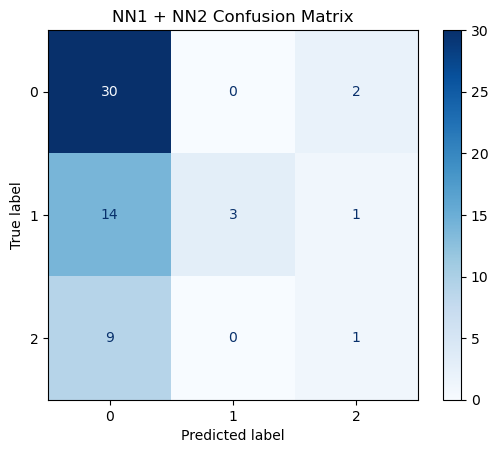

In [656]:
matrix = create_confusion_matrix(y_test_overall, y_preds_overall, cmap=plt.cm.Blues)
plt.title('NN1 + NN2 Confusion Matrix')
plt.show(matrix)
plt.show()

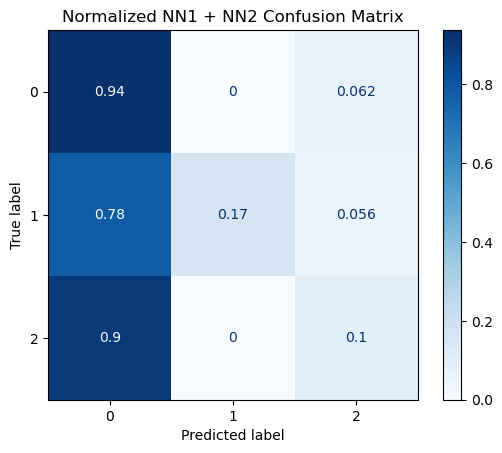

In [657]:
matrix = create_confusion_matrix(y_test_overall, y_preds_overall, cmap=plt.cm.Blues, normalize = 'true')
plt.title('Normalized NN1 + NN2 Confusion Matrix')
plt.show(matrix)
plt.show()

In [658]:
# 3-way scores
y_test_np = y_test.to_numpy()
my_classification_report(y_test_overall, y_preds_overall)

y_test_bin = label_binarize(y_test_overall, classes = [0, 1, 2])
y_pred_bin = label_binarize(y_preds_overall, classes = [0, 1, 2])

Precision
G34 0.5660377144813538
SHH 1.0
WNT 0.25
Macro Avg: 0.6053459048271179
Recall
G34 0.9375
SHH 0.1666666716337204
WNT 0.10000000149011612
Macro Avg: 0.40138888359069824
F1
G34 0.7058823704719543
SHH 0.2857142984867096
WNT 0.1428571492433548
Macro Avg: 0.3781512975692749
multiclass acc: tensor(0.5667)


### Confidence Intervals

In [659]:
n_classes = 3

n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test_overall), len(y_test_overall))
    if len(np.unique(y_test_overall[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] ##
    one_npv = [] ##
    for i in range(n_classes):
        one_acc.append(accuracy_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_spec.append(specificity_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_prec.append(precision_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_rec.append(recall_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_f_one.append(f1_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices])) ##
        one_npv.append(negative_pv_score(y_test_bin[:, i][indices], y_pred_bin[:, i][indices])) ##

    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv) ##
    bootstrapped_npv_scores.append(one_npv) ##

/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ZeroDivisionError: division by zero

In [ ]:
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV") ##
create_ci(bootstrapped_npv_scores, "NPV") ##

## Individual Classification Results

In [ ]:
metadata_df = df['molecular']
target_for_table = df['molecular']

In [ ]:
# features_for_table = df.drop(['molecular','molec_id', 'dx_date','alive','os','pfs','seg_id'], axis = 1)
features_for_table = df.drop(columns='molecular')
# target_for_table = target_for_table.map(dict(group3=0, shh = 1, wnt = 2))
target_for_table = target_for_table.map({
    'group3': 0,
    'group4': 0,
    'shh': 1,
    'wnt': 2,
})

In [ ]:
#only used for metadata for which is train and which is test
# X_train_for_table, X_test_for_table, _, _ = train_test_split(features_for_table, target_for_table,
#                                                     test_size = 0.25, random_state = 42)
X_train_for_table = features_for_table[train_idx]
X_test_for_table = features_for_table[test_idx]

In [ ]:
X_train_for_table['Set'] = 'training'
X_test_for_table['Set'] = 'test'

In [ ]:
X_for_table = pd.concat([X_train_for_table, X_test_for_table])
X_for_table = pd.merge(metadata_df, X_for_table, left_index = True, right_index = True)

In [ ]:
final_df = X_for_table[['molecular', 'Set']]
# features_for_table = df.drop(['molecular','molec_id', 'dx_date','alive','os','pfs','seg_id'], axis = 1)
features_for_table = df.drop(columns='molecular')
target_for_table = X_for_table['molecular']
target_for_table = target_for_table.map(dict(group3 = 0, shh = 1, wnt = 2))

In [ ]:
X_table_reduced = features_for_table[reduced_features_list]

In [ ]:
# sex_binarized = X_table_reduced['sex'].map(dict(M = 1, F = 0)).to_numpy()
#
# X_table_reduced['sex'] = sex_binarized

In [ ]:
names = X_table_reduced.columns
X_table_for_first = first_scaler.transform(X_table_reduced)
X_table_for_first = pd.DataFrame(X_table_for_first, columns = names)

In [ ]:
y_probs_after_first_table = nn_seq_1_model.predict_proba(X_table_for_first)

In [ ]:
rf_1_table = pd.DataFrame(y_probs_after_first_table, columns = ['NN1 Group3 Prob','NN1 Non-Group3 Prob'])

In [ ]:
final_df['NN1 Group3 Prob'] = rf_1_table['NN1 Group3 Prob']
final_df['NN1 Non-Group3 Prob'] = rf_1_table['NN1 Non-Group3 Prob']

In [ ]:
y_preds_after_first_table = nn_seq_1_model.predict(X_table_for_first)
wnt_table_indices = np.where(y_preds_after_first_table == 0)
other_table_indices = np.where(y_preds_after_first_table != 0)

In [ ]:
y_table_for_wnt = np.array(y_preds_after_first_table)[wnt_table_indices]
X_table_after_first_model = features_for_table.iloc[other_table_indices]
X_table_after_first_model = X_table_after_first_model[second_reduced_features_list]
X_table_after_first_model_arr = second_scaler.transform(X_table_after_first_model)

In [ ]:
y_probs_after_second_table = nn_seq_2_model.predict_proba(X_table_after_first_model_arr)
y_preds_after_second_table = nn_seq_2_model.predict(X_table_after_first_model_arr)

In [ ]:
nn_2_table = pd.DataFrame(y_probs_after_second_table, columns = ['NN2 SHH Prob','NN2 WNT Prob'])

In [ ]:
X_table_after_first_model['NN2 SHH Prob'] = np.array(nn_2_table['NN2 SHH Prob'])
X_table_after_first_model['NN2 WNT Prob'] = np.array(nn_2_table['NN2 WNT Prob'])

In [ ]:
X_table_after_first_model = X_table_after_first_model[['NN2 SHH Prob', 'NN2 WNT Prob']]

In [ ]:
final_df = final_df.merge(X_table_after_first_model, how='left', left_index=True, right_index=True)

In [ ]:
def f(row):
    if row['NN1 Non-Group3 Prob'] < row['NN1 Group3 Prob']:
        val = 'group3'
    else:
        if row['NN2 SHH Prob'] > row['NN2 WNT Prob']:
            val = 'shh'
        else:
            val = 'wnt'
    return val

In [ ]:
# final_df['molec_id'] = df['molec_id']

In [ ]:
final_df['Pred Path'] = final_df.apply(f, axis = 1)

In [ ]:
# Formatting
# final_df.columns = ['True Molec', 'Set', 'NN1 Non-Group3 Prob', 'NN1 Group3 Prob', 'NN2 SHH Prob', 'NN2 WNT Prob', 'Molec Id', 'Pred Molec']
final_df.columns = ['True Molec', 'Set', 'NN1 Non-Group3 Prob', 'NN1 Group3 Prob', 'NN2 SHH Prob', 'NN2 WNT Prob', 'Pred Molec']
cols = final_df.columns.tolist()
cols = ['NN1 Non-Group3 Prob', 'NN1 Group3 Prob', 'NN2 SHH Prob', 'NN2 WNT Prob',
        'Pred Molec', 'True Molec', 'Set']
final_df = final_df[cols]
final_df = final_df.round(4)

In [ ]:
# Formatting
# final_df.columns = ['True Molec', 'Set', 'NN1 Non-Group3 Prob', 'NN1 Group3 Prob', 'NN2 SHH Prob', 'NN2 WNT Prob', 'Molec Id', 'Pred Molec']
final_df.columns = ['True Molec', 'Set', 'NN1 Non-Group3 Prob', 'NN1 Group3 Prob', 'NN2 SHH Prob', 'NN2 WNT Prob', 'Pred Molec']
cols = final_df.columns.tolist()
cols = ['NN1 Non-Group3 Prob', 'NN1 Group3 Prob', 'NN2 SHH Prob', 'NN2 WNT Prob',
        'Pred Molec', 'True Molec', 'Set']
final_df = final_df[cols]
final_df = final_df.round(4)

In [ ]:
pd.set_option('display.max_rows', None)
print(final_df)

In [ ]:
final_df.to_csv('seq_classification_results.csv')